# Digit Recognition ensemble learning

The Goal of this project is to train different ensemble models and connect them to a base model

In [1]:
# Importing all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

In [2]:
# Reading the dataset into pandas DataFrame
df = pd.read_csv("train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


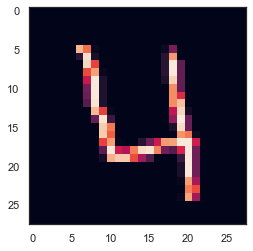

In [3]:
#visualising our dataset using matplotlib
image0 = df.iloc[3,1:]
image0                                                
plt.imshow(np.array(image0).reshape(28,28))     

# Data splitting 

- we will split the dataset into test and train sets
- training set will be used to train our models
- testing set will be used to test our model

In [4]:
x = df.iloc[:,1:]
y = df.iloc[:,0]
from sklearn.model_selection import train_test_split
xtrain , xtest ,ytrain, ytest = train_test_split(x,y,test_size =0.2,shuffle = False,random_state =7)

#### Cross Validation 

In [5]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

#### Training models without parameters 

we are training the follwoing models before parameters 
- SVC
- Random Forest
- KNN

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


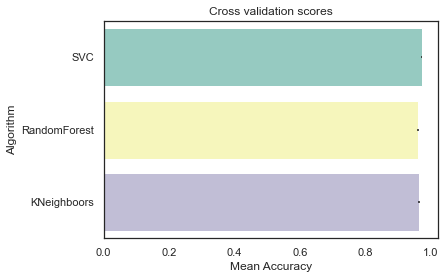

In [6]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, xtrain, y = ytrain, scoring = "accuracy", cv = kfold, n_jobs=1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","RandomForest","KNeighboors"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


we got the accuracy above 90% on all the three models 
#### GridSearchCV tuninig 

now lets tune the models using GridSearchCV

In [7]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1,2,3],
              "min_samples_split": [2,3,4],
              "min_samples_leaf": [1,2],
              "bootstrap": [False],
              "n_estimators" :[10],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsRFC.fit(xtrain,ytrain)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


0.9180357142857144

In [8]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'C': [1]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)

gsSVMC.fit(xtrain,ytrain)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


0.9727678571428571

In [10]:
# KNeighbors 
model = KNeighborsClassifier(n_neighbors=3)
model.fit(xtrain,ytrain)
y_pred = model.predict(xtest)

In [11]:
model.score(xtest,ytest)

0.9695238095238096

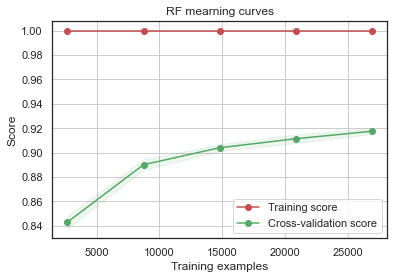

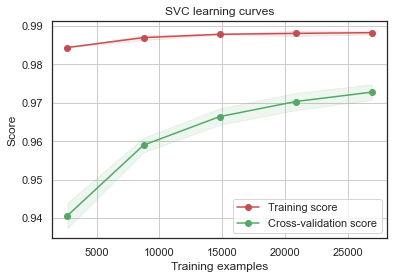

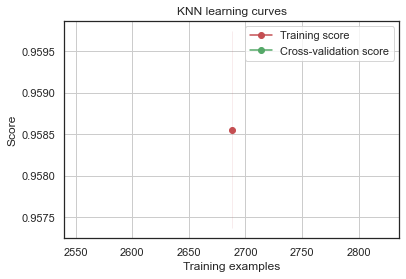

In [12]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",xtrain,ytrain,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",xtrain,ytrain,cv=kfold)
# g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(model,"KNN learning curves",xtrain,ytrain,cv=kfold)


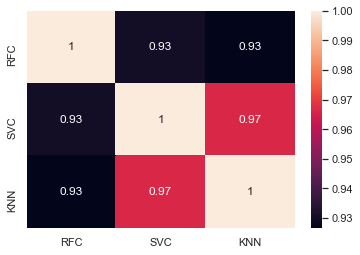

In [14]:
test_Survived_RFC = pd.Series(RFC_best.predict(xtest), name="RFC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(xtest), name="SVC")
# test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_KNN = pd.Series(model.predict(xtest), name="KNN")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_SVMC,test_Survived_KNN],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

#### ensembling the models

we are ensembling the above models into a base model

In [15]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
('svc', SVMC_best),('KNN',model)], voting='soft', n_jobs=4)

votingC = votingC.fit(xtrain,ytrain)

In [16]:
votingC.score(xtest,ytest)

0.9779761904761904